In [1]:
# The GPU id to use, either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="7";  

In [2]:
# !conda create --name steffen-voxelmorph-python3.7_tf2.4.1 python=3.7 tensorflow-gpu=2.4.1 ipykernel ipywidgets notebook jupyter
# !conda activate steffen-voxelmorph-python3.7_tf2.4.1
# !pip install voxelmorph  # for all things voxelmorph/neurite
# !pip install tensorflow_addons  # for tqdm callbacks


In [3]:
# screen
# conda activate steffen-voxelmorph-python3.7_tf2.4.1
# conda install runipy
# runipy brain3D_ourdata.ipynb
# or
# jupyter nbconvert --to notebook --execute brain3D_ourdata.ipynb --output executed.ipynb

In [4]:
# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()


# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

2021-09-27 01:10:15.033523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
# prepare data
# !ln -s /mnt/FileSystem-DeepLearning/vnm/qsm28_data/realigned_bias-corrected_skullstripped_rescaled-0-1 ourdata
# test = nib.load('ourdata/sub-201506121000S26NF_ses-01_T1w_brain_preproc_1mm.nii.gz').get_fdata()
# print(test.shape)

files = ['ourdata/' + f for f in os.listdir('ourdata') if f.endswith('preproc_1mm.nii.gz')]
vols = [nib.load(f).get_fdata()[0:144,0:200,0:224] for f in tqdm(files)]

  0%|          | 0/29 [00:00<?, ?it/s]

x_vols_full.shape:  (29, 144, 200, 224, 1)
x_vols.shape:  (29, 144, 192, 160, 1)


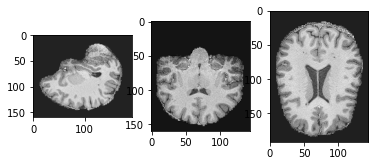

In [6]:
x_vols_full = np.expand_dims(np.stack(vols, 0), -1)
print('x_vols_full.shape: ', x_vols_full.shape)
x_vols = x_vols_full[:,0:144,0:192,50:210]
print('x_vols.shape: ', x_vols.shape)
vol_shape = x_vols.shape[1:-1]


# visualize input data
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(x_vols[2,100,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(x_vols[2,:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(x_vols[2,:,:,100], -1), cmap='gray')

In [7]:
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow 

2021-09-27 01:10:52.079154: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 01:10:52.080039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-27 01:10:52.216987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:da:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-09-27 01:10:52.217025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-27 01:10:52.218186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-27 01:10:52.218214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-09-

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [8]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [3])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs


In [9]:
# let's make sure the sizes make sense
sample = next(template_gen(x_vols, 8))
[print(f.shape) for f in sample[0]], [print(f.shape) for f in sample[1]]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

print(vol_shape)

(8, 144, 192, 160, 1)
(8, 144, 192, 160, 1)
(8, 144, 192, 160, 1)
(8, 144, 192, 160, 3)
(8, 144, 192, 160, 3)
(8, 144, 192, 160, 3)
(144, 192, 160)


In [10]:
# creat model
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])


LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [11]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
# train
gen = template_gen(x_vols, batch_size=1)
hist = model.fit(gen, epochs=1, steps_per_epoch=1, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

2021-09-27 01:11:21.630706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-27 01:11:21.642350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:da:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-09-27 01:11:21.642488: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-27 01:11:21.642666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-27 01:11:21.642714: I tensorflow/stream_executor/platform/defau

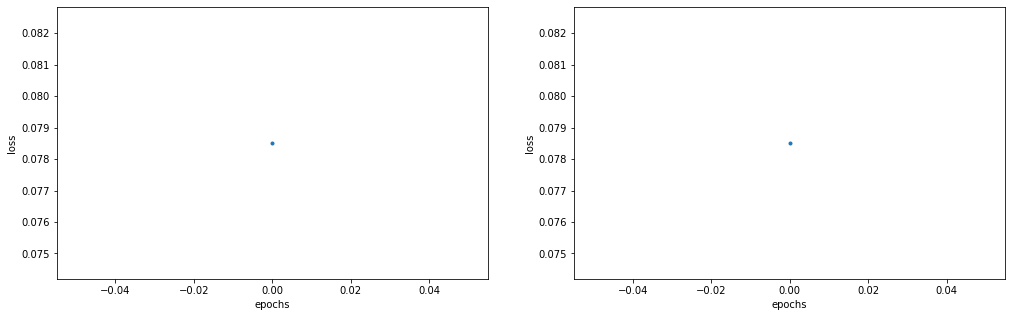

In [13]:
# visualize optimization
plot_hist(hist)

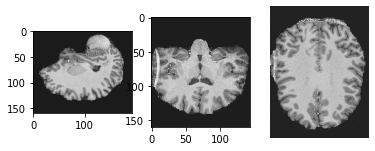

In [14]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(atlas[100,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(atlas[:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(atlas[:,:,100], -1), cmap='gray')
plt.axis('off');
plt.axis('off');